In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from pathlib import Path
from dataclasses import dataclass
from mbeml.constants import LigandFeatures, TargetProperty
from mbeml.featurization import data_prep
from mbeml.plotting import color_dict, marker_dict, core_legend, scatter_random_z

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
data_dir = Path("../../data/")

df_lig_test = pd.read_csv(data_dir / "ligand_test_data.csv")

model_dir = Path("../../models/")

In [4]:
@dataclass
class Experiment:
    name: str
    features: LigandFeatures
    target: TargetProperty = TargetProperty.SSE
    is_nn: bool = False
    prediction = np.zeros(len(df_lig_test))
    uncertainty = np.zeros(len(df_lig_test))

In [5]:
krr_experiments = [
    Experiment("krr_standard_racs", features=LigandFeatures.STANDARD_RACS),
    Experiment("krr_two_body", features=LigandFeatures.LIGAND_RACS),
    Experiment("krr_three_body", features=LigandFeatures.LIGAND_RACS),
]
nn_experiments = [
    Experiment("nn_standard_racs", features=LigandFeatures.STANDARD_RACS, is_nn=True),
    Experiment("nn_two_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
    Experiment("nn_three_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
]

In [6]:
for experiment in krr_experiments + nn_experiments:
    x, _ = data_prep(
        df_lig_test, experiment.features, experiment.target, experiment.is_nn
    )
    # Evaluate model
    if experiment.is_nn:
        model = tf.keras.models.load_model(
            model_dir / experiment.target.name.lower() / experiment.name
        )
        experiment.prediction, experiment.uncertainty = model.predict(x, verbose=0)
    else:
        with open(
            model_dir / experiment.target.name.lower() / f"{experiment.name}.pkl",
            "rb",
        ) as fin:
            model = pickle.load(fin)
        y_mean, y_std = model.predict(x, return_std=True)
        experiment.prediction = y_mean.reshape(-1, 1)
        experiment.uncertainty = y_std.reshape(-1, 1)

2024-02-14 08:45:46.127655: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# NN models

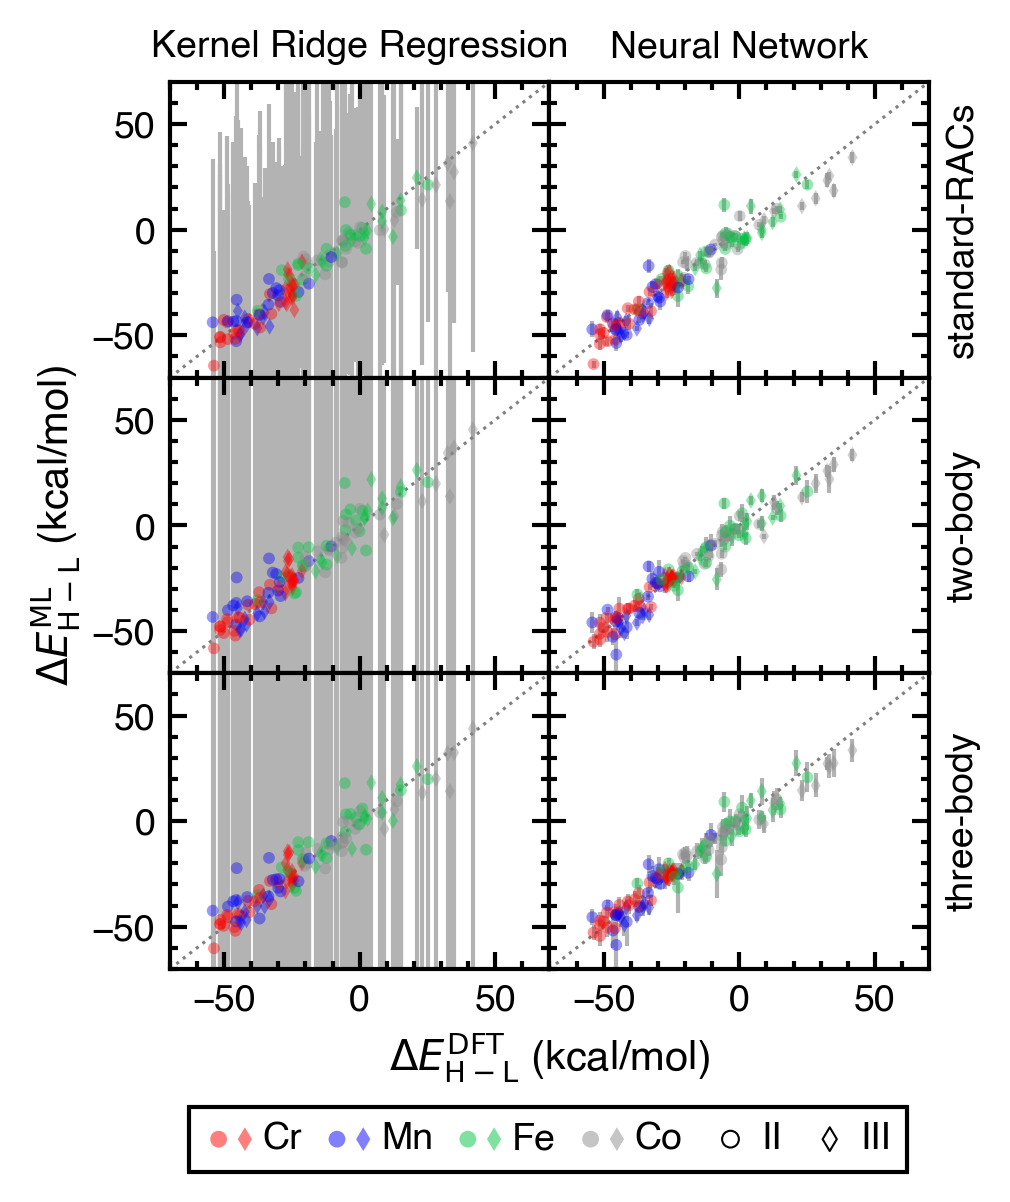

In [7]:
_, y = data_prep(df_lig_test, LigandFeatures.STANDARD_RACS, TargetProperty.SSE, False)
cores = df_lig_test[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values

figsize = (3.33, 1.2 * 3.33)
fig = plt.figure(figsize=figsize)
gridspec_kw = {
    "left": 0.16,
    "right": 0.92,
    "top": 0.93,
    "bottom": 0.19,
    "hspace": 0.0,
    "wspace": 0.0,
}
axes = fig.subplots(
    ncols=2,
    nrows=3,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

scatter_kwargs = {"s": 8, "alpha": 0.4, "edgecolors": "none"}
lower_lim = -70
upper_lim = 70

for experiment, ax in zip(krr_experiments + nn_experiments, axes.T.flatten()):
    colors = np.array([color_dict[core[:2]] for core in cores])
    markers = np.array([marker_dict[core[-1]] for core in cores])
    scatter_random_z(
        ax,
        y,
        experiment.prediction,
        colors,
        markers,
        **scatter_kwargs,
    )
    ax.errorbar(
        y.flatten(),
        experiment.prediction.flatten(),
        yerr=2.0 * experiment.uncertainty.flatten(),
        color="0.7",
        linestyle="None",
        zorder=-10,
    )
    # Plot parity line:
    ax.plot(
        [lower_lim, upper_lim],
        [lower_lim, upper_lim],
        color="0.5",
        linewidth=0.75,
        zorder=0.5,
        linestyle=":",
    )
    # Set limits and ticks
    ax.set_xlim([lower_lim, upper_lim])
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xticks(10 * np.arange(lower_lim // 10, upper_lim // 10), minor=True)
    ax.set_yticks(10 * np.arange(lower_lim // 10, upper_lim // 10), minor=True)

fig.text(
    gridspec_kw["left"] + 0.5 * (gridspec_kw["right"] - gridspec_kw["left"]),
    gridspec_kw["bottom"] - 0.085,
    "$\Delta E^\mathrm{DFT}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    ha="center",
)
fig.text(
    0.02,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "$\Delta E^\mathrm{ML}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    rotation=90,
    va="center",
)

for i, label in enumerate(["standard-RACs", "two-body", "three-body"]):
    axes[i, -1].set_ylabel(label, fontsize=9)
    axes[i, -1].yaxis.set_label_position("right")
axes[0, 0].set_title("Kernel Ridge Regression", fontsize=9)
axes[0, 1].set_title("Neural Network", fontsize=9)

# Legend
core_legend(
    axes[-1, 0],
    legend_kwargs=dict(
        loc="lower left",
        bbox_to_anchor=[0.0, -0.75],
        markerscale=0.9,
        handletextpad=0.08,
        columnspacing=0.52,
    ),
)

fig.savefig("plots/parity_plot_sse_lig_test.pdf")